In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2

C:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 32
img_height = 256
img_width = 256

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory('./Chess',
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=123,
                                                        image_size=(img_height, img_width),
                                                        batch_size=batch_size)

Found 552 files belonging to 6 classes.
Using 442 files for training.


In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory('./Chess',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        seed=123,
                                                        image_size=(img_height, img_width),
                                                        batch_size=batch_size)

Found 552 files belonging to 6 classes.
Using 110 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']


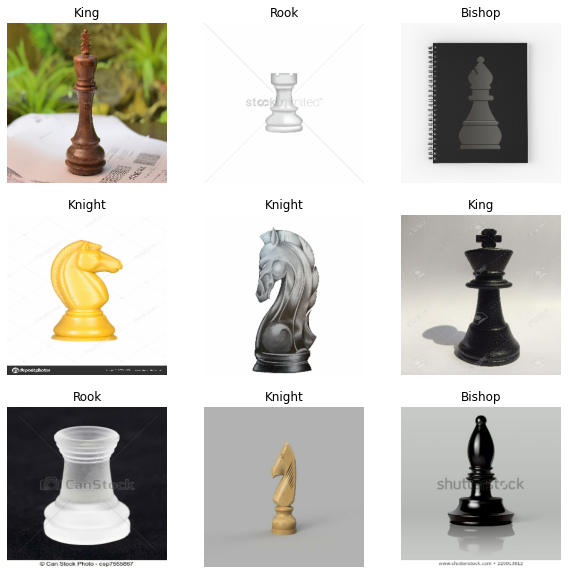

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.023083737 1.0


In [11]:
num_classes = len(class_names)

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [14]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
14/14 [==============================] - 16s 1s/step - loss: 3.8682 - accuracy: 0.2104 - val_loss: 1.7958 - val_accuracy: 0.2000
Epoch 2/10
14/14 [==============================] - 13s 944ms/step - loss: 1.7678 - accuracy: 0.2330 - val_loss: 1.7883 - val_accuracy: 0.2000
Epoch 3/10
14/14 [==============================] - 13s 913ms/step - loss: 1.7245 - accuracy: 0.2873 - val_loss: 1.7630 - val_accuracy: 0.2455
Epoch 4/10
14/14 [==============================] - 16s 1s/step - loss: 1.5786 - accuracy: 0.3688 - val_loss: 1.7664 - val_accuracy: 0.2636
Epoch 5/10
14/14 [==============================] - 16s 1s/step - loss: 1.2922 - accuracy: 0.5158 - val_loss: 1.8112 - val_accuracy: 0.2818
Epoch 6/10
14/14 [==============================] - 14s 973ms/step - loss: 1.0205 - accuracy: 0.6131 - val_loss: 1.9217 - val_accuracy: 0.2909
Epoch 7/10
14/14 [==============================] - 13s 942ms/step - loss: 0.7692 - accuracy: 0.7489 - val_loss: 2.1250 - val_accuracy: 0.2818
Epoch 8/

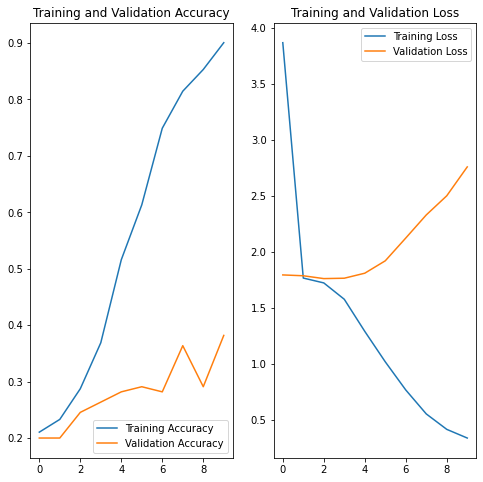

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
score = model.evaluate(train_ds, verbose=0) 
print('Validation score:', score[0]) 
print('Validation accuracy:', score[1])

Validation score: 0.259791761636734
Validation accuracy: 0.929864227771759
